## Heart Attack Prediction Model  
## Hyperparameters Tuning
## Advanced Modeling & Evaluation
## Final Model Selection

---


## Author: Will Wu

## Date: 2025-03-21
---

## Introduction
- The objective of this notebook is to focus on hyperparameter tuning and the development of more advanced and complex models built upon the foundation of baseline models. Following the modeling phase, I will conduct model evaluation and comparative analysis to identify the best-performing model that aligns with the project’s goals.
- Before delving into advanced modeling techniques, I will provide a brief recap on the success metrics and share additional insights from the research. This will help readers and users better understand how thresholds are determined and the rationale behind selecting the optimal models:
    1. The primary objective of this project is to identify users at risk for heart attacks by maximizing the recall score. However, this could lead to a high false positive rate, resulting in many false alarms for individuals not at risk, which may incur unnecessary healthcare costs.
    2. Research on cardiac disease prediction models shows inherent randomness and unpredictability in assessing heart attack risk, often resulting in a tradeoff between recall and false positive rates. While adjusting model thresholds can improve recall, it may also increase false positives, potentially compromising reliability.
    3. For instance, the Framingham Coronary Heart Disease Study reports a sensitivity (recall) score of 0.6 to 0.7 with a false positive rate of about 0.4. Similarly, tools like the ASCVD Risk Estimator have a recall of 60% to 75% for identifying  cardiovascular risk, with similar tradeoffs in false positives.
    4. Based on the results of the baseline models, most have a recall score of approximately 0.76 and a false positive rate around 0.2.
- **To meet the goal of this project, I will manually adjust the thresholds of various models after training to achieve a recall score of 0.80, allowing the model to identify 80% users who are genuinely at risk for heart attacks. After standardizing the recall score across models, I will compare the false positive rates, selecting the model with the lowest rate. Ideally, the false positive rate should remain below 20% or be as low as possible to minimize the number of users receiving false alarms about heart attack risk.**
- Given the runtime considerations and the comparable performance of the baseline model using both downsampling and upsampling techniques, I will use downsampling for the grid search of optimal hyperparameter combinations.

---

## **Table of Contents** ##
1. [Setup and Load Data](#1)
2. [Data Preparation](#2)
3.  [Logistic Regression](#3)
    - [Grid Search](#3a)
    - [Train the model](#3b)
    - [Model Evaluation](#3c)
    - [Adjust Threshold & Reevaluation](#3d)
    - [Summary](#3e)
4.  [Naive Bayes](#4)
    - [Grid Search](#4a)
    - [Train the model](#4b)
    - [Model Evaluation](#4c)
    - [Adjust Threshold & Reevaluation](#4d)
    - [Summary](#4e)
5.  [Decision Tree](#5)
    - [Grid Search](#5a)
    - [Train the model](#5b)
    - [Model Evaluation](#5c)
    - [Adjust Threshold & Reevaluation](#5d)
    - [Summary](#5e)
6.  [Random Forest](#6)
    - [Grid Search](#6a)
    - [Train the model](#6b)
    - [Model Evaluation](#6c)
    - [Adjust Threshold & Reevaluation](#6d)
    - [Summary](#6e)
7.  [XGBoost](#7)
    - [Grid Search](#7a)
    - [Train the model](#7b)
    - [Model Evaluation](#7c)
    - [Additional Hyperparameters Tuning](#7d)
    - [Model Comparison and Summary](#7e)
    - [Adjust Threshold & Reevaluation](#7f)
    - [Summary](#7g)
8. [Neural Network](#8)
    - [Preparations](#8a)
    - [Neural Network With Default Loss Function](#8b)
    - [Neural Network With Customized Loss Function](#8c)
    - [Model Comparison & Summary](#8d)
9. [Advanced Model Comparison and Summary](#9)
    - [Model Comparison and Final Model Selection](#9a)
    - [Understanding the Metrics](#9b)
10. [Export Model and Threshold](#10)


---

## 1. Setup and Loading<a class="anchor" id="1"></a>

In [121]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
import joblib
from model_evaluator import ModelEvaluator
from resampler import DownSampler


In [106]:
# Configure Seaborn to use 'darkgrid' as the default background style
sns.set_style('darkgrid')

# Setting figure size, fontsize globally in the notebook
plt.rcParams["figure.figsize"] = (6.0, 6.0)

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [ ]:
# Load original dataframe, and the data with feature selection
df_original = pd.read_csv('../data/processed/df_original.csv')
df_selected = pd.read_csv('../data/processed/df_feature_selected.csv')

In [4]:
# Check shape
print(f'The shape of original DataFrame without feature selection is: {df_original.shape}')
print(f'The shape of feature-selected DataFrame is: {df_selected.shape}')

The shape of original DataFrame without feature selection is: (751985, 38)
The shape of feature-selected DataFrame is: (751985, 20)


---

## 2. Data Preparation <a class="anchor" id="2"></a>

Create X and y on selected features

In [5]:
# Get X and y
X = df_selected[[col for col in df_selected.columns if col != 'had_heart_attack']]
y = df_selected['had_heart_attack']

---

Train Test Split

In [ ]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=1)

Create sample of train data for hyperparameter tuning.

In [7]:
# Create sample for X_train, y_train
X_sample = X_train.sample(frac=0.3, random_state=1)
y_sample = y_train[X_sample.index]

# Print size for sanity check
print(f'The size of X_sample is {X_sample.shape}')
print(f'The size of y_sample is {y_sample.shape}')
print(f'The value counts (%) in y_sample is: {y_sample.value_counts(normalize=True).round(4) * 100}')

The size of X_sample is (169196, 19)
The size of y_sample is (169196,)
The value counts (%) in y_sample is: had_heart_attack
0    94.72
1     5.28
Name: proportion, dtype: float64


---

Create ColumnTransformer for One Hot Encoding

In [8]:
# Get categorial and numeric features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include='number').columns.tolist()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_cols', OneHotEncoder(sparse_output=False), categorical_features),  # Apply OneHotEncoder to categorical features
        ('num_cols', 'passthrough', numeric_features)         # Keep numeric features untouched
    ]
)

I will build a pipeline that incorporates resampling, one-hot encoding, and scaling. With these preprocessing steps in place, I will proceed to explore different models for hyperparameter tuning and finalize model selection.

---

## 3. Logistic Regression <a class="anchor" id="3"></a>

### 3.1 Grid Search <a class="anchor" id="3a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [ ]:
# Create the pipeline for grid search using logistic regression
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [10]:
# Create hyperparameter grid for logistic regression
params_grid = {
    'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga', 'liblinear'],
}

Hyperparameter grid search for optimal recall score

In [11]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [12]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [13]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of logistic regression for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of logistic regression for optimal recall score: 


{'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}

The best hyperparameters for logistic regression with optimimal recall score are: C=0.001, penalty=l2, solver=saga. 

---

### 3.2 Train the model <a class="anchor" id="3b"></a>

In [23]:
# Create pipeline using the optimal hyperparameters
pipeline_logreg_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=0.001, penalty='l2' ,solver='saga', random_state=42))
])

# Fit the model
pipeline_logreg_final.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDEEFAC50>),
                ('encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressive_disorder',
                                                   'had_arthritis',
                                                   'deaf_or_hard_of_hearing',
                                                   'blind_or_vision_difficulty',
                                                   'difficulty_walking',
                                                   'difficulty_dressing_bathing']),
                                                 ('num_cols', 'passthrough',
                                                  ['is_female',
                                                   'physical_activities',
                                                   'had_angina',
                                                   'had_stroke'])])),
                ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001, random_state=42, solver='saga'))])

---

### 3.3 Model Evaluation <a class="anchor" id="3c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

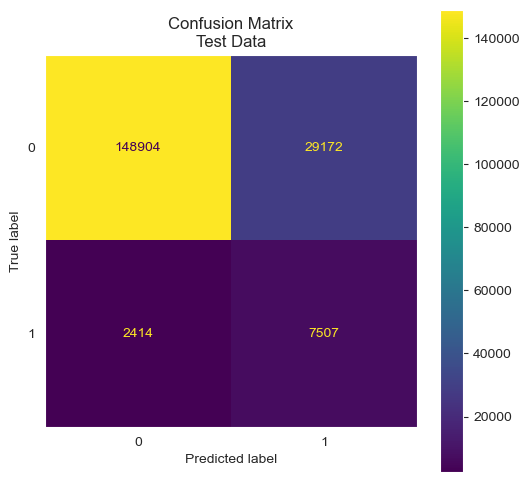

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.84      0.90    178076
           1       0.20      0.76      0.32      9921

    accuracy                           0.83    187997
   macro avg       0.59      0.80      0.61    187997
weighted avg       0.94      0.83      0.87    187997

Recall Score:
Train: 0.758
Test: 0.757 
False Positive Rate:
Train: 0.163
Test: 0.164 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.833
Test: 0.832 
Precision Score:
Train: 0.206
Test: 0.205 
F1 Score:
Train: 0.324
Test: 0.322 


In [24]:
# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline_logreg_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: Logistic Regression


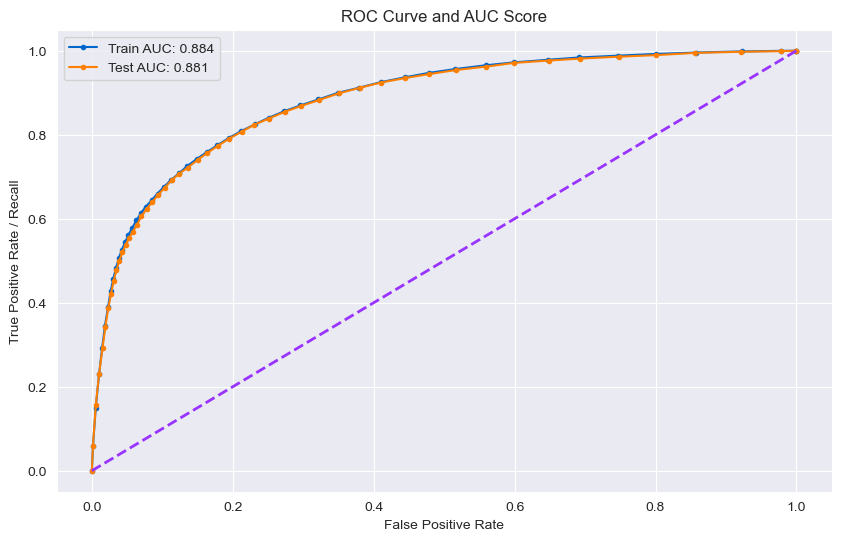

In [17]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Logistic Regression')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 3.4 Adjust Threshold & Reevaluation <a class="anchor" id="3d"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [39]:
# Create variable for target recall score
target_recall = 0.80

# Get the probablistic prediction on test dataset
y_pred_test_proba = pipeline_logreg_final.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.4487


In [40]:
# Create a DataFrame to store the thresholds of different models
optimal_threshold_df = pd.DataFrame(columns=['model', 'thresholds'])

In [41]:
# Store the threshold
logreg_thresholds = pd.DataFrame({'model': ['logistic_regression'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, logreg_thresholds], axis=0, ignore_index=True)
logreg_thresholds

,model,thresholds
0,logistic_regression,0.448738


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

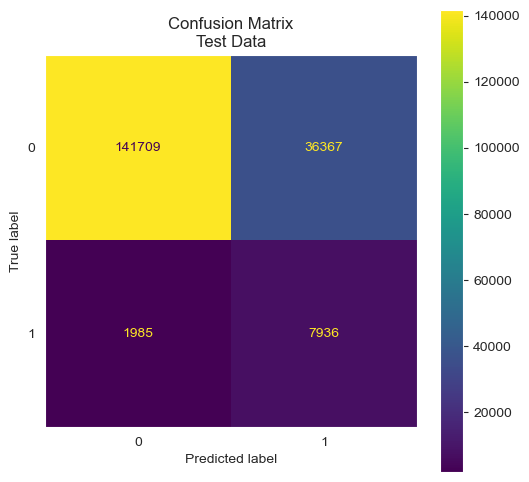

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.801
Test: 0.800 
False Positive Rate:
Train: 0.204
Test: 0.204 
AUC Score:
Train: 0.884
Test: 0.881 
Accuracy Score:
Train: 0.796
Test: 0.796 
Precision Score:
Train: 0.180
Test: 0.179 
F1 Score:
Train: 0.293
Test: 0.293 


In [53]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(pipeline_logreg_final)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

Store the recall and fpr for train and test data

In [84]:
# Create DataFrames to store the important metrics 
recall_final_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
    )

fpr_final_model = pd.DataFrame(
    index=['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network'],
    columns=['Train', 'Test']
)

In [86]:
# Store the metrics of logistic regression
recall_final_model.loc['Logistic Regression', : ] = [0.801, 0.800]
fpr_final_model.loc['Logistic Regression', : ] = [0.204, 0.204]

---

### 3.5 Logistic Regression Model Summary <a class="anchor" id="3e"></a>

**Metrics using test data:**
random_state=42, no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| Logistic Regression   | Downsampling     | 0.4487      | 0.800   | 0.204  | 0.881  | 0.796     | 0.179      | 0.293     |  C=0.001, penalty=l2, solver=saga  | Final       |


---

## 4. Naive Bayes <a class="anchor" id="4"></a>

### 4.1 Grid Search <a class="anchor" id="4a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [54]:
# Create the pipeline for grid search using naive bayes
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('nb' , GaussianNB())
])

In [55]:
# Create params for naive bayes
params_grid = {
    'nb__var_smoothing': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

Hyperparameter grid search for optimal recall score

In [56]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [57]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [58]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of naive bayes for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of naive bayes for optimal recall score: 


{'nb__var_smoothing': 0.001}

The best hyperparameters for naive bayes with optimimal recall score are: var_smoothing = 0.001 

---

### 4.2 Train the model <a class="anchor" id="4b"></a>

In [45]:
# Create pipeline using the optimal hyperparameters
pipeline_nb_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('nb' , GaussianNB(var_smoothing= 0.001))
])

# Fit the model
pipeline_nb_final.fit(X_train, y_train)

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDF235990>),
                ('one_hot_encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressive_disorder',
                                                   'had_arthritis',
                                                   'deaf_or_hard_of_hearing',
                                                   'blind_or_vision_difficulty',
                                                   'difficulty_walking',
                                                   'difficulty_dressing_bathing']),
                                                 ('num_cols', 'passthrough',
                                                  ['is_female',
                                                   'physical_activities',
                                                   'had_angina',
                                                   'had_stroke'])])),
                ('scaler', StandardScaler()),
                ('nb', GaussianNB(var_smoothing=0.001))])

---

### 4.3 Model Evaluation <a class="anchor" id="4c"></a>

Confusion matrices: 


<Figure size 300x300 with 0 Axes>

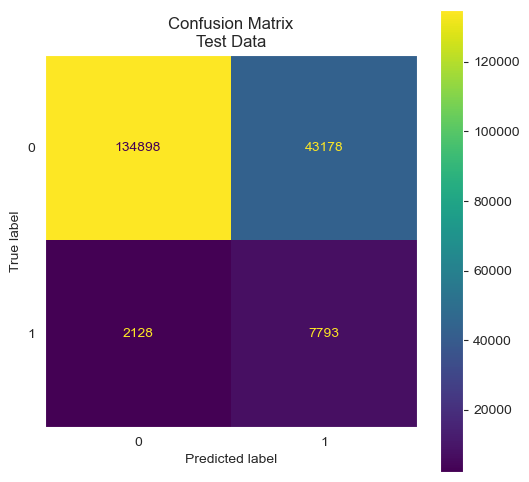

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.76      0.86    178076
           1       0.15      0.79      0.26      9921

    accuracy                           0.76    187997
   macro avg       0.57      0.77      0.56    187997
weighted avg       0.94      0.76      0.82    187997

Recall Score:
Train: 0.786
Test: 0.786 
False Positive Rate:
Train: 0.241
Test: 0.242 
AUC Score:
Train: 0.837
Test: 0.835 
Accuracy Score:
Train: 0.760
Test: 0.759 
Precision Score:
Train: 0.154
Test: 0.153 
F1 Score:
Train: 0.257
Test: 0.256 


In [46]:
# Use self-built ModelEvaluator to evaluate the mode
evaluator = ModelEvaluator(pipeline_nb_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: Naive Bayes


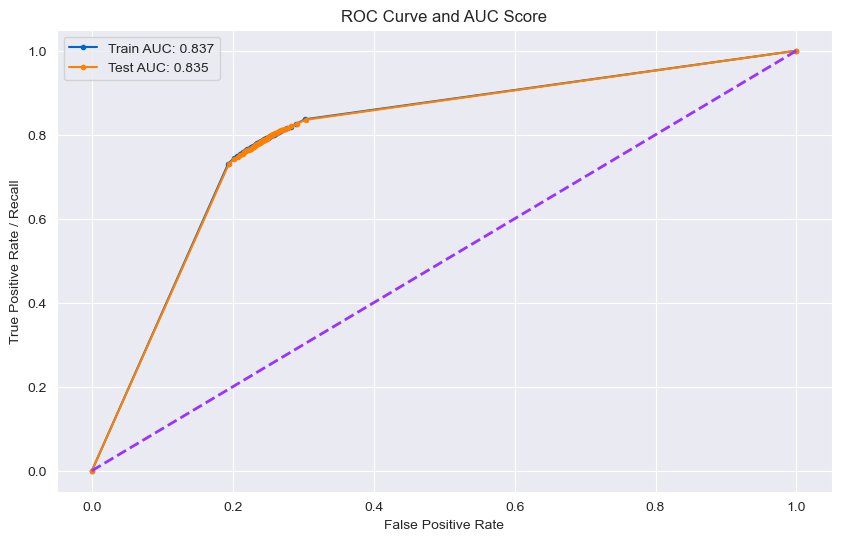

In [47]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Naive Bayes')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 4.4 Adjust Threshold & Reevaluation <a class="anchor" id="4d"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [48]:
# Create variable for target recall score
target_recall = 0.80

# Get the probablistic prediction on test dataset
y_pred_test_proba = pipeline_nb_final.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.2715


In [49]:
# Store the threshold
nb_thresholds = pd.DataFrame({'model': ['naive_bayes'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, nb_thresholds], axis=0, ignore_index=True)
optimal_threshold_df

,model,thresholds
0,logistic_regression,0.448738
1,naive_bayes,0.271518


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

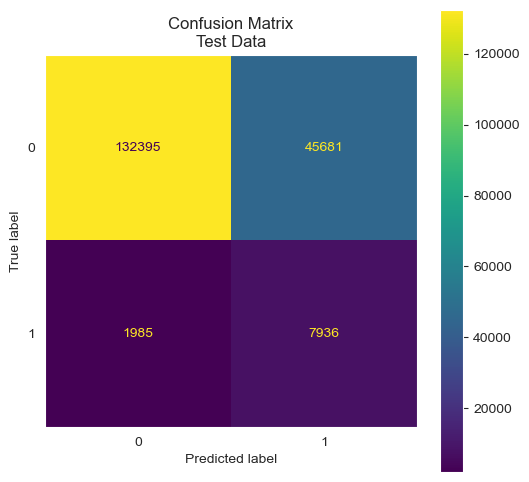

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.74      0.85    178076
           1       0.15      0.80      0.25      9921

    accuracy                           0.75    187997
   macro avg       0.57      0.77      0.55    187997
weighted avg       0.94      0.75      0.82    187997

Recall Score:
Train: 0.799
Test: 0.800 
False Positive Rate:
Train: 0.255
Test: 0.257 
AUC Score:
Train: 0.837
Test: 0.835 
Accuracy Score:
Train: 0.747
Test: 0.746 
Precision Score:
Train: 0.148
Test: 0.148 
F1 Score:
Train: 0.250
Test: 0.250 


In [64]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(pipeline_nb_final)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

In [ ]:
# Store the metrics of naive bayes
recall_final_model.loc['Naive Bayes', : ] = [0.799, 0.800]
fpr_final_model.loc['Naive Bayes', : ] = [0.255, 0.257]

---

### 4.5 Naive Bayes Model Summary <a class="anchor" id="4e"></a>

**Metrics using test data:**<br>
no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| Naive Bayes   | Downsampling     | 0.2715      | 0.800   | 0.257  | 0.835  | 0.746     | 0.148      | 0.250     |  var_smoothing= 0.001  | Final       |





---

## 5. Decision Tree <a class="anchor" id="5"></a>

### 5.1 Grid Search <a class="anchor" id="5a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [ ]:
# Create the pipeline for grid search using decision tree
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier())
])

Phase 1 - Initial hyperparameter grid search for optimal recall score

In [ ]:
# Create hyperparameter grid for decision tree
params_grid = {
    'dtc__max_depth': [3, 7, 12, 18],
    'dtc__min_samples_split': [3, 5, 8, 12, 20],
    'dtc__min_samples_leaf': [15, 30, 75, 100],
    'dtc__criterion': ['gini', 'entropy']
}

In [67]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [68]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [69]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'dtc__criterion': 'entropy',
 'dtc__max_depth': 12,
 'dtc__min_samples_leaf': 75,
 'dtc__min_samples_split': 5}

Phase 2 - Conduct hyperparameter grid search with a refined and narrower range of values

In [ ]:
# Create the pipeline for grid search using decision tree
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(criterion='entropy'))
])

In [ ]:
# Create hyperparameter grid for decision tree
params_grid = {
    'dtc__max_depth': [9, 10, 11, 12, 13, 14],
    'dtc__min_samples_split': [4, 5, 6, 7],
    'dtc__min_samples_leaf': [70, 75, 80, 85],
}

In [112]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [113]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [115]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'dtc__max_depth': 11,
 'dtc__min_samples_leaf': 80,
 'dtc__min_samples_split': 4}

The best hyperparameters for decision tree with optimimal recall score are: max_depth=11, min_samples_split=4, min_samples_leaf=80, criterion=entropy

---

### 5.2 Train the model <a class="anchor" id="5b"></a>

In [50]:
# Create pipeline using the optimal hyperparameters
pipeline_dt_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(max_depth=11, 
                                  min_samples_split=4,
                                  min_samples_leaf=80, 
                                  criterion='entropy',
                                  random_state=42))
])

# Fit the model
pipeline_dt_final.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDE9F8110>),
                ('encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressive_disor...
                                                   'deaf_or_hard_of_hearing',
                                                   'blind_or_vision_difficulty',
                                                   'difficulty_walking',
                                                   'difficulty_dressing_bathing']),
                                                 ('num_cols', 'passthrough',
                                                  ['is_female',
                                                   'physical_activities',
                                                   'had_angina',
                                                   'had_stroke'])])),
                ('scaler', StandardScaler()),
                ('dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=11,
                                        min_samples_leaf=80,
                                        min_samples_split=4,
                                        random_state=42))])

---

### 5.3 Model Evaluation <a class="anchor" id="5c"></a>

Decision Tree
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

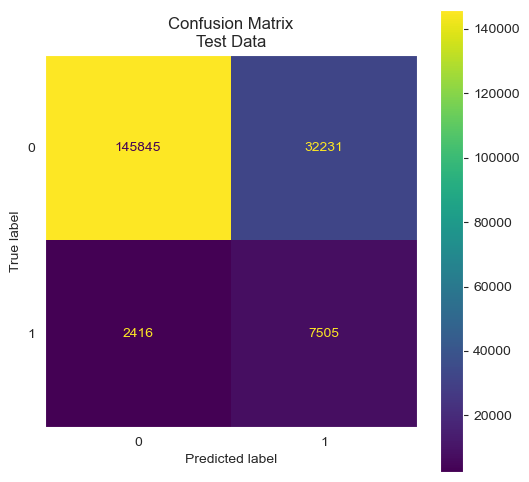

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.76      0.30      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.79      0.60    187997
weighted avg       0.94      0.82      0.86    187997

Recall Score:
Train: 0.771
Test: 0.756 
False Positive Rate:
Train: 0.181
Test: 0.181 
AUC Score:
Train: 0.877
Test: 0.870 
Accuracy Score:
Train: 0.816
Test: 0.816 
Precision Score:
Train: 0.192
Test: 0.189 
F1 Score:
Train: 0.307
Test: 0.302 


In [30]:
# Use self-built ModelEvaluator to evaluate the mode
print('======='*8)
print('Decision Tree')
print('======='*8)
evaluator = ModelEvaluator(pipeline_dt_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: Decision Tree


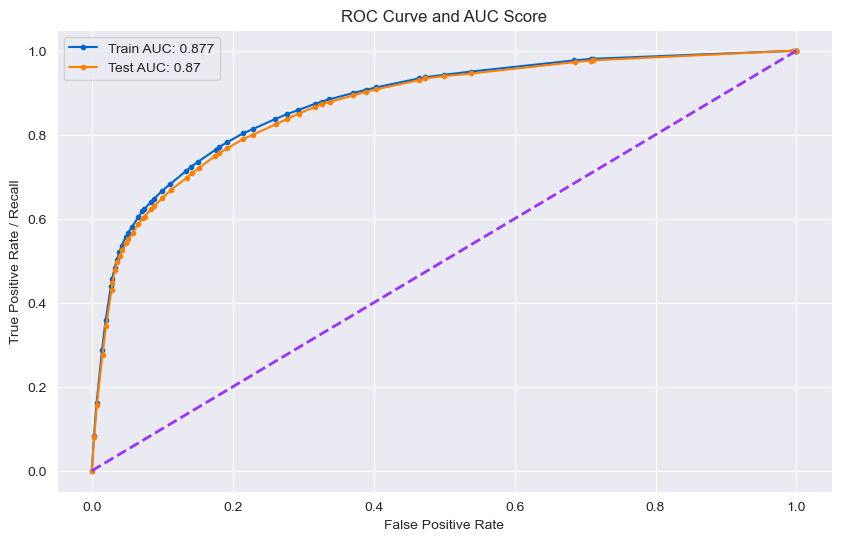

In [19]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Decision Tree')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 5.4 Adjust Threshold & Reevaluation <a class="anchor" id="5d"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [51]:
# Create variable for target recall score
target_recall = 0.8000

# Get the probablistic prediction on test dataset
y_pred_test_proba = pipeline_dt_final.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.4440


In [52]:
# Store the threshold
dt_thresholds = pd.DataFrame({'model': ['decision_tree'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, dt_thresholds], axis=0, ignore_index=True)
optimal_threshold_df

,model,thresholds
0,logistic_regression,0.448738
1,naive_bayes,0.271518
2,decision_tree,0.444043


Confusion matrices: 


<Figure size 300x300 with 0 Axes>

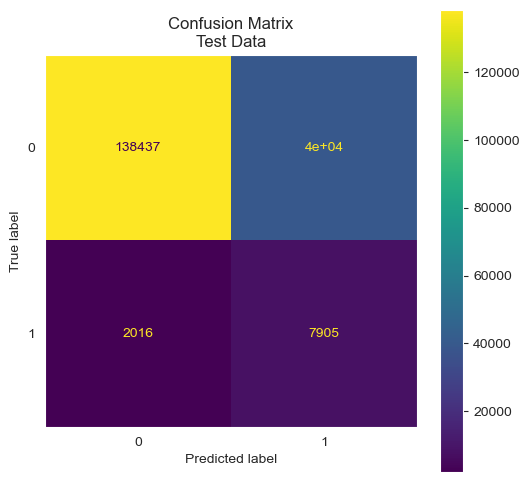

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.78      0.87    178076
           1       0.17      0.80      0.28      9921

    accuracy                           0.78    187997
   macro avg       0.58      0.79      0.57    187997
weighted avg       0.94      0.78      0.84    187997

Recall Score:
Train: 0.809
Test: 0.797 
False Positive Rate:
Train: 0.222
Test: 0.223 
AUC Score:
Train: 0.877
Test: 0.870 
Accuracy Score:
Train: 0.780
Test: 0.778 
Precision Score:
Train: 0.169
Test: 0.166 
F1 Score:
Train: 0.279
Test: 0.275 


In [178]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(pipeline_dt_final)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

In [ ]:
# Store the metrics of decision tree
recall_final_model.loc['Decision Tree', : ] = [0.809, 0.709]
fpr_final_model.loc['Decision Tree', : ] = [0.222, 0.223]

---

### 5.5 Decision Tree Model Summary <a class="anchor" id="5e"></a>

**Metrics using test data:**<br>
random_state=42, no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| Decision Tree   | Downsampling     | 0.4440      | 0.797   | 0.223  | 0.870  | 0.778    | 0.166      |0.275 |  max_depth=11, min_samples_split=4, min_samples_leaf=80, criterion=entropy  | Final       |





---

## 6. Random Forest <a class="anchor" id="6"></a>

### 6.1 Grid Search <a class="anchor" id="6a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [ ]:
# Create the pipeline for grid search using random forest
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

Phase 1 - Initial hyperparameter grid search for optimal recall score

In [105]:
# Create hyperparameter grid for random_forest
params_grid = {
    'rfc__n_estimators': [50, 100, 150],
    'rfc__max_depth': [7, 10, 15],
    'rfc__min_samples_split': [5, 15, 30, 60],
    'rfc__min_samples_leaf': [15, 50, 100],
    'rfc__bootstrap': [True, False]
}

In [106]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [107]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [109]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of random forest for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of random forest for optimal recall score: 


{'rfc__bootstrap': False,
 'rfc__max_depth': 15,
 'rfc__min_samples_leaf': 100,
 'rfc__min_samples_split': 5,
 'rfc__n_estimators': 50}

Phase 2 - Conduct hyperparameter grid search with a refined and narrower range of values

In [ ]:
# Create updated pipeline for grid search using random forest
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(bootstrap=False))
])

In [ ]:
# Create hyperparameter grid for random_forest
params_grid = {
    'rfc__n_estimators': [90, 100, 110],
    'rfc__max_depth': [13, 15, 17],
    'rfc__min_samples_split': [4, 5, 6, 7],
    'rfc__min_samples_leaf': [40, 50, 60]
}

In [96]:
# Create GridSearch CV, set scoring as recall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [98]:
# Fit using X_sample and y_sample
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [99]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of random forest for optimal recall: ")
fitted_grid_recall.best_params_

The hyperparameters of random forest for optimal recall: 


{'rfc__max_depth': 17,
 'rfc__min_samples_leaf': 60,
 'rfc__min_samples_split': 4,
 'rfc__n_estimators': 100}

Since some of the best hyperparameters are on the edge of the selected range, I will conduct another grid search to identify the optimal hyperparameters.

Phase 3 - Conduct hyperparameter grid search with a refined and narrower range of values

In [123]:
# Create updated pipeline for grid search using random forest
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(n_estimators=100, 
                                   bootstrap=False))
])

In [124]:
# Create hyperparameter grid for random_forest
params_grid = {
    'rfc__max_depth': [16, 17, 18, 19],
    'rfc__min_samples_split': [3, 4, 5],
    'rfc__min_samples_leaf': [60, 70, 80, 90]
}

In [125]:
# Create GridSearch CV, set scoring as recall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [126]:
# Fit using X_sample and y_sample
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [127]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of random forest for optimal recall: ")
fitted_grid_recall.best_params_

The hyperparameters of random forest for optimal recall: 


{'rfc__max_depth': 16,
 'rfc__min_samples_leaf': 80,
 'rfc__min_samples_split': 3}

The best hyperparameters for random forest with optimimal recall score are: max_depth=16, min_samples_leaf=80, min_samples_split=3, n_estimators=100, bootstrap=False

---

### 6.2 Train the model <a class="anchor" id="6b"></a>

In [53]:
# Create pipeline using the optimal hyperparameters
pipeline_rf_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(
        n_estimators=100,
        max_depth=16,
        min_samples_leaf=80,
        min_samples_split=3,
        bootstrap=False,
        random_state=42
    ))
])

# Fit the model
pipeline_rf_final.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDF240E90>),
                ('one_hot_encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressi...
                                                   'had_arthritis',
                                                   'deaf_or_hard_of_hearing',
                                                   'blind_or_vision_difficulty',
                                                   'difficulty_walking',
                                                   'difficulty_dressing_bathing']),
                                                 ('num_cols', 'passthrough',
                                                  ['is_female',
                                                   'physical_activities',
                                                   'had_angina',
                                                   'had_stroke'])])),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, max_depth=16,
                                        min_samples_leaf=80,
                                        min_samples_split=3,
                                        random_state=42))])

---

### 6.3 Model Evaluation <a class="anchor" id="6c"></a>

Random Forest
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

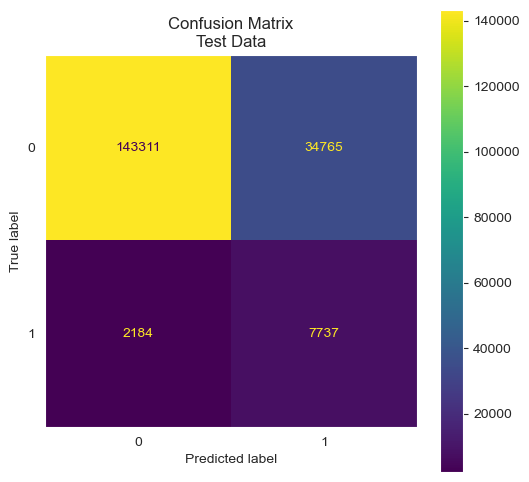

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.80      0.89    178076
           1       0.18      0.78      0.30      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.79      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.790
Test: 0.780 
False Positive Rate:
Train: 0.195
Test: 0.195 
AUC Score:
Train: 0.883
Test: 0.878 
Accuracy Score:
Train: 0.804
Test: 0.803 
Precision Score:
Train: 0.184
Test: 0.182 
F1 Score:
Train: 0.299
Test: 0.295 


In [32]:
# Use self-built ModelEvaluator to evaluate the mode
print('========'*8)
print('Random Forest')
print('========'*8)
evaluator = ModelEvaluator(pipeline_rf_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: Random Forest


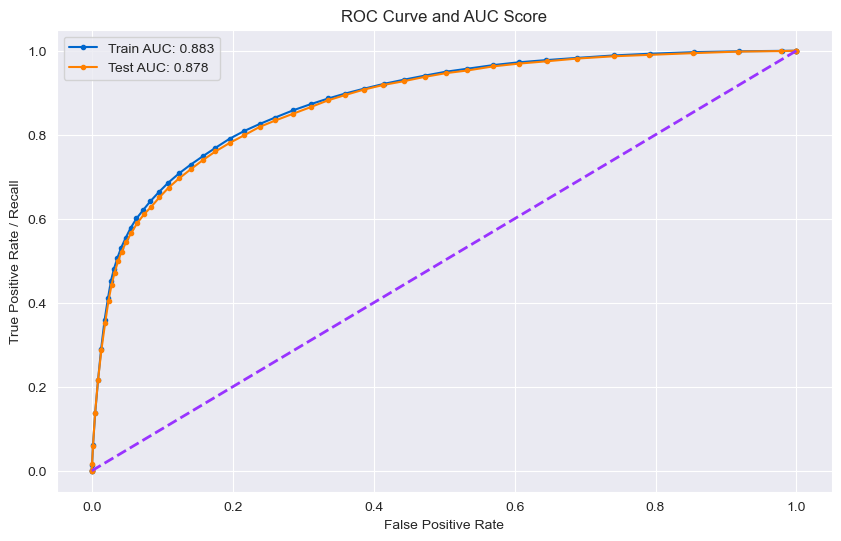

In [164]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: Random Forest')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 6.4 Adjust Threshold & Reevaluation <a class="anchor" id="6d"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [54]:
# Create variable for target recall score
target_recall = 0.8000

# Get the probablistic prediction on test dataset
y_pred_test_proba = pipeline_rf_final.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.4791


In [55]:
# Store the threshold
rf_thresholds = pd.DataFrame({'model': ['random_forest'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, rf_thresholds], axis=0, ignore_index=True)
optimal_threshold_df

,model,thresholds
0,logistic_regression,0.448738
1,naive_bayes,0.271518
2,decision_tree,0.444043
3,random_forest,0.479093


ROC Curve: Random Forest
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

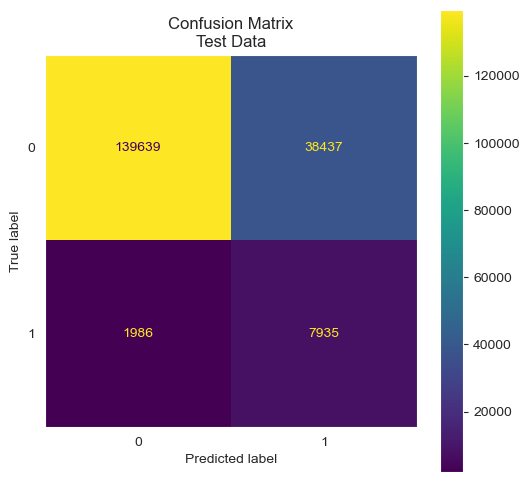

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.78      0.87    178076
           1       0.17      0.80      0.28      9921

    accuracy                           0.78    187997
   macro avg       0.58      0.79      0.58    187997
weighted avg       0.94      0.78      0.84    187997

Recall Score:
Train: 0.808
Test: 0.800 
False Positive Rate:
Train: 0.216
Test: 0.216 
AUC Score:
Train: 0.883
Test: 0.878 
Accuracy Score:
Train: 0.786
Test: 0.785 
Precision Score:
Train: 0.173
Test: 0.171 
F1 Score:
Train: 0.284
Test: 0.282 


In [183]:
# Re-evaluate the model using the new threshold
print('========'*8)
print('Random Forest')
print('========'*8)
evaluator = ModelEvaluator(pipeline_rf_final)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

In [90]:
# Store the metrics of random forest
recall_final_model.loc['Random Forest', : ] = [0.808, 0.800]
fpr_final_model.loc['Random Forest', : ] = [0.216, 0.216]

---

### 6.5 Random Forest Model Summary <a class="anchor" id="6e"></a>

**Metrics using test data:** <br>
random_state=42, no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| Random Forest  | Downsampling     | 0.4791      | 0.800   | 0.216   | 0.878  | 0.785    | 0.171    |0.282  |  max_depth=16, min_samples_leaf=80, min_samples_split=3, n_estimators=100, bootstrap=False | Final       |





---

## 7. XGBoost <a class="anchor" id="7"></a>

### 7.1 Grid Search <a class="anchor" id="7a"></a>

Create pipelines and hyperparameter dictionary for grid search

In [33]:
# Create the pipeline for grid search using XGBoost
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

Phase 1 - Initial hyperparameter grid search for optimal recall score

In [199]:
# Create hyperparameter grid for XGBoost
params_grid = {
    'xgb__n_estimators': [50, 100, 200],         
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],       
    'xgb__max_depth': [5, 12, 20],             
    'xgb__min_child_weight': [1, 5, 7],  
    'xgb__subsample': [0.8, 1.0],         
}

In [200]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [201]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [203]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 12,
 'xgb__min_child_weight': 7,
 'xgb__n_estimators': 50,
 'xgb__subsample': 0.8}

Phase 2 - Conduct hyperparameter grid search with a refined and narrower range of values

In [204]:
# Create the pipeline for grid search using XGBoost
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

In [205]:
params_grid = {
    'xgb__n_estimators': [35, 50, 65],         
    'xgb__learning_rate': [0.08, 0.1, 0.12],       
    'xgb__max_depth': [11, 12, 13, 14],             
    'xgb__min_child_weight': [7, 10, 13],         
    'xgb__subsample': [0.6, 0.7, 0.8],  
}

In [206]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [207]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [208]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'xgb__learning_rate': 0.12,
 'xgb__max_depth': 13,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 65,
 'xgb__subsample': 0.7}

Phase 3 - Conduct hyperparameter grid search with a refined and narrower range of values

In [215]:
# Create the pipeline for grid search using XGBoost
pipeline = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  # Use fixed class
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(max_depth=13, subsample=0.7, min_child_weight=10))
])

In [216]:
params_grid = {
    'xgb__n_estimators': [65, 80],         
    'xgb__learning_rate': [0.12, 0.14, 0.16],
    'xgb__reg_lambda': [0.1, 1, 10],    # L2 regularization
    'xgb__reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization             
}

In [217]:
# Create GridSearch CV, set scoring as reacall for optimizing recall
grid_recall = GridSearchCV(pipeline, params_grid, scoring='recall', n_jobs=-1, cv=StratifiedKFold(5))

In [218]:
# Fit using X_sample and y_sample 
fitted_grid_recall = grid_recall.fit(X_sample, y_sample)

In [219]:
# Show the best hyperparameters for optimal recall score
print("The hyperparameters of decision tree for optimal recall score: ")
fitted_grid_recall.best_params_

The hyperparameters of decision tree for optimal recall score: 


{'xgb__learning_rate': 0.12,
 'xgb__n_estimators': 80,
 'xgb__reg_alpha': 1,
 'xgb__reg_lambda': 10}

The best hyperparameters for XGBoost with optimimal recall score are:   n_estimators=80, learning_rate=0.12, max_depth=13, min_child_weight=10, subsample=0.7, reg_alpha=1, reg_lambda=10.

---

### 7.2 Train the model <a class="anchor" id="7b"></a>

In [56]:
# Create pipeline using the optimal hyperparameters
pipeline_xgb_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=80,
        learning_rate=0.12,
        max_depth=13,
        min_child_weight=10,
        subsample=0.7,
        reg_alpha=1,
        reg_lambda=10,
        random_state=42
    ))
])

# Fit the model
pipeline_xgb_final.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDEF3B7D0>),
                ('one_hot_encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressi...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.12,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=13, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

---

### 7.3 Model Evaluation <a class="anchor" id="7c"></a>

XGBoost
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

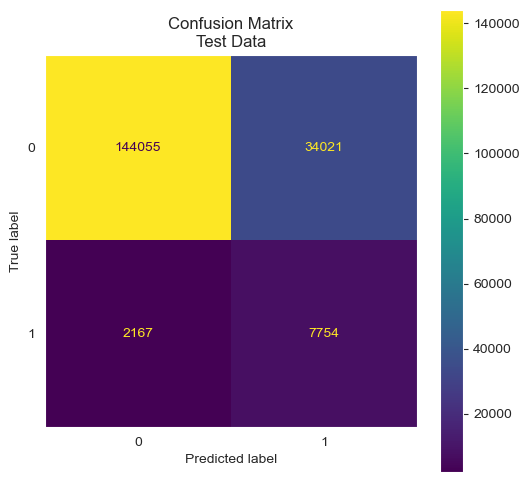

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.81      0.89    178076
           1       0.19      0.78      0.30      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.59    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.812
Test: 0.782 
False Positive Rate:
Train: 0.189
Test: 0.191 
AUC Score:
Train: 0.895
Test: 0.881 
Accuracy Score:
Train: 0.811
Test: 0.808 
Precision Score:
Train: 0.193
Test: 0.186 
F1 Score:
Train: 0.312
Test: 0.300 


In [231]:
# Use self-built ModelEvaluator to evaluate the mode
print('======='*8)
print('XGBoost')
print('======='*8)
evaluator = ModelEvaluator(pipeline_xgb_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: XGBoost


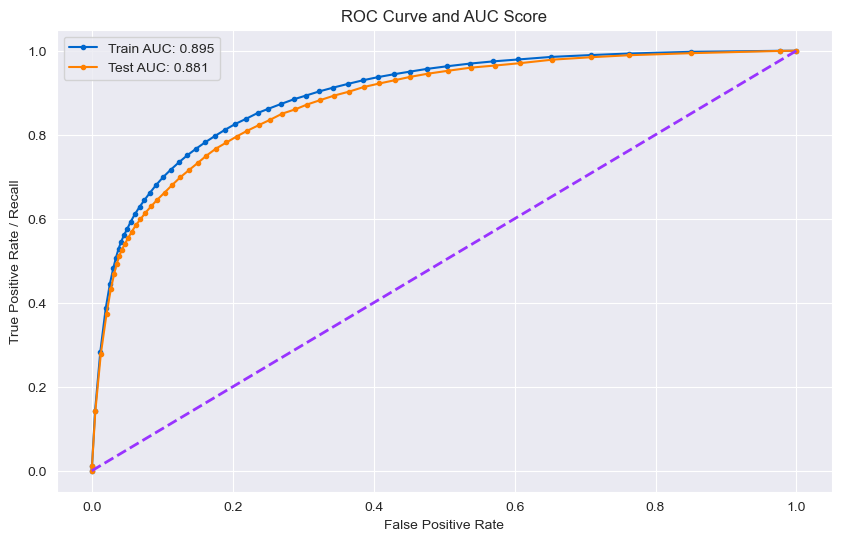

In [232]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: XGBoost')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

**Takeaways:**<br>
The model shows signs of overfitting after hyperparameter tuning. Overfitting increases the model's variance and may lead to poor performance on unseen data. Therefore, it is crucial to address this issue, possibly through manual hyperparameter adjustments.

---

### 7.4 Additional Hyperparameters Tuning, Training, and Evaluation <a class="anchor" id="7d"></a>

Based on the hyperparameters used in the model above, I plan to manually adjust some of them to reduce overfitting.

In [57]:
# Create pipeline using the optimal hyperparameters
pipeline_xgb_final = Pipeline([
    ('downsampler', DownSampler(random_state=1)),  
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=40,
        learning_rate=0.12,
        max_depth=11,
        min_child_weight=10,
        subsample=0.7,
        reg_alpha=1,
        reg_lambda=10,
        random_state=42
    ))
])

# Fit the model
pipeline_xgb_final.fit(X_train, y_train) 

Pipeline(steps=[('downsampler',
                 <resampler.DownSampler object at 0x000002BFDEF3BB50>),
                ('one_hot_encoding',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['race_ethnicity_category',
                                                   'age_category',
                                                   'bmi_category',
                                                   'alcohol_drinkers',
                                                   'general_health',
                                                   'smoker_status', 'had_copd',
                                                   'had_diabetes',
                                                   'had_kidney_disease',
                                                   'had_depressi...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.12,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=40,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

XGBoost
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

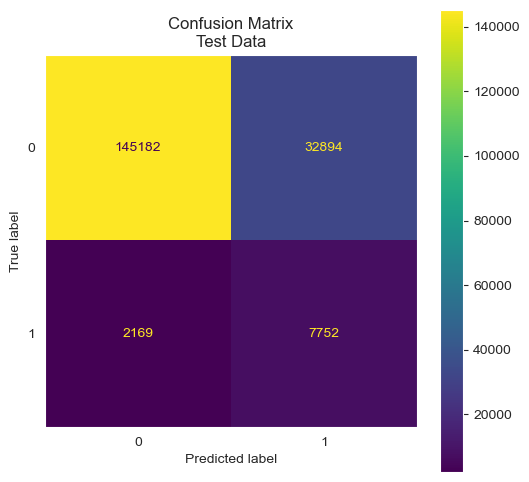

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.82      0.89    178076
           1       0.19      0.78      0.31      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.794
Test: 0.781 
False Positive Rate:
Train: 0.183
Test: 0.185 
AUC Score:
Train: 0.891
Test: 0.883 
Accuracy Score:
Train: 0.816
Test: 0.813 
Precision Score:
Train: 0.195
Test: 0.191 
F1 Score:
Train: 0.313
Test: 0.307 


In [43]:
# Use self-built ModelEvaluator to evaluate the mode
print('======='*8)
print('XGBoost')
print('======='*8)
evaluator = ModelEvaluator(pipeline_xgb_final)
evaluator.evaluate(X_train, X_test, y_train, y_test)

ROC Curve: XGBoost


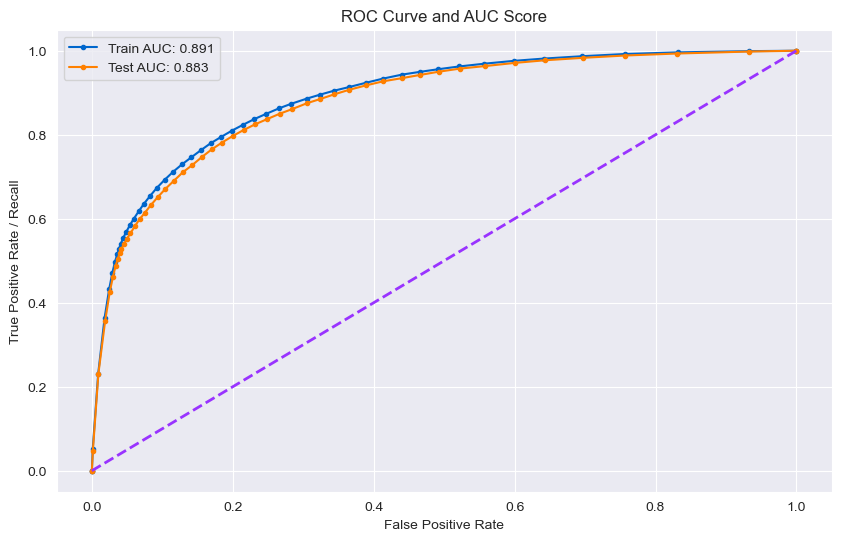

In [44]:
# Plot the roc curve 
print('======='*8)
print('ROC Curve: XGBoost')
print('======='*8)
evaluator.plot_roc_auc_curve(X_train, X_test, y_train, y_test)

---

### 7.5 Model Comparison and Summary  <a class="anchor" id="7e"></a>
All of the metrics are displayed in 
| Model     | Recall | FPR  | AUC  | Hyperparameters | Notes          |
|-----------|--------|------|------|-----------------|----------------|
|XGBoost  | 0.812/0.782   | 0.189/0.191 | 0.895/0.881 | n_estimators=80, learning_rate=0.12, max_depth=13, min_child_weight=10, subsample=0.7, reg_alpha=1, reg_lambda=10 | Exhibit overfitting.  |
|**XGBoost**    | **0.794/0.781**   | **0.183/0.185** | 0.891/0.883 | n_estimators=40, learning_rate=0.12, max_depth=11, min_child_weight=10, subsample=0.7, reg_alpha=1, reg_lambda=10 | **Manual hyperparameter tuning has resolved the overfitting issue. Picked as the Final Model.**  |

- Overfitting is clearly evident in the first model, as the recall and AUC scores on the training data significantly exceeded those on the test data. This overfitting increases the model's variance and can lead to poor performance on unseen data.
- By manually reducing the `n_estimators` (number of trees) and `max_depth` (maximum depth of each tree), the overfitting issue was resolved in the second model.
- The **second model** not only demonstrated **no signs of overfitting**, but also **improved the false positive rate (FPR) by 1.4%** with **only a 0.1% decrease in recall score**. Therefore, the second model will be selected as the **best XGBoost model**.

---

### 7.6 Adjust Threshold & Reevaluation <a class="anchor" id="7f"></a>


Identify thresholds where the recall on the test set is greater than or equal to 0.80, and re-evaluate the model using the updated thresholds.

In [58]:
# Create variable for target recall score
target_recall = 0.8000

# Get the probablistic prediction on test dataset
y_pred_test_proba = pipeline_xgb_final.predict_proba(X_test)[:, 1]  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

For recall score to reach the target of 0.80, the threshold should be updated to: 0.4765


In [59]:
# Store the threshold
xgb_thresholds = pd.DataFrame({'model': ['xgboost'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, xgb_thresholds], axis=0, ignore_index=True)
optimal_threshold_df

,model,thresholds
0,logistic_regression,0.448738
1,naive_bayes,0.271518
2,decision_tree,0.444043
3,random_forest,0.479093
4,xgboost,0.476502


XGBoost
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

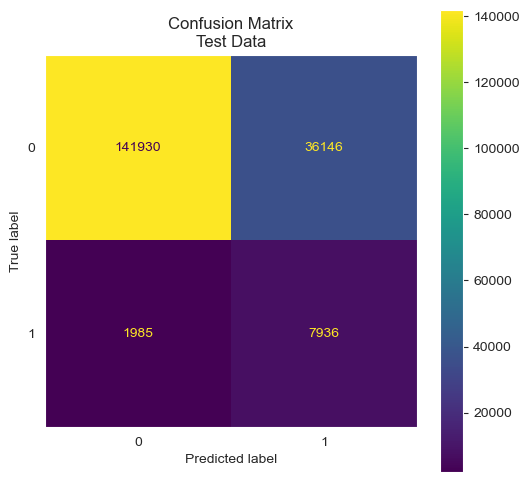

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.812
Test: 0.800 
False Positive Rate:
Train: 0.202
Test: 0.203 
AUC Score:
Train: 0.891
Test: 0.883 
Accuracy Score:
Train: 0.799
Test: 0.797 
Precision Score:
Train: 0.183
Test: 0.180 
F1 Score:
Train: 0.299
Test: 0.294 


In [263]:
# Re-evaluate the model using the new threshold
print('========'*8)
print('XGBoost')
print('========'*8)
evaluator = ModelEvaluator(pipeline_xgb_final)
evaluator.evaluate(X_train, X_test, y_train, y_test, thresholds=model_threshold)

In [91]:
# Store the metrics of XGBoost
recall_final_model.loc['XGBoost', : ] = [0.812, 0.800]
fpr_final_model.loc['XGBoost', : ] = [0.202, 0.203]

---

### 7.7 XGBoost Model Summary <a class="anchor" id="7g"></a>

**Metrics using test data:** <br>
random_state=42, no PCA

| Model       | Resample Method | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Hyperparameters                      | Notes                    |
|-------------|------------------|-----------|--------|-------|-------|----------|-----------|----------|--------------------------------------|--------------------------|
| XGBoost   | Downsampling     | 0.4765      | 0.800   | 0.203   | 0.883  | 0.797    | 0.180    |0.294 | n_estimators=40, learning_rate=0.12, max_depth=11, min_child_weight=10, subsample=0.7, reg_alpha=1, reg_lambda=10 | Final





---

## 8. Neural Network <a class="anchor" id="8"></a>

-  In this section, I will utilize class weights in the neural network to effectively learn from both classes during training. This approach enables the model to treat the minority class with greater importance, allowing for a better balance in predictions without compromising the amount of training data. By maintaining the full dataset, the model can leverage all available information, and this might result in better model performance.
- In the baseline modeling process, the neural network slightly outperformed the other baseline models with a better balance between recall and false positive rate. In this section, I will train the neural network with a more complex structure and tune the hyperparameters to evaluate if it can further improve the model's predictability.
- Additionally, I will create a customized loss function that aims to optimize recall and the false positive rate. I will compare the model using this custom loss function with the default loss function, BinaryCrossentropy(), to assess which approach better fits the goals of this project.

---

### 8.1 Preparations <a class="anchor" id="8a"></a>

Train Validation Split <br>
- Since the model training is not built in the pipeline, I need to manually separate the train dataset into additional train and validation data for training the neural network.

In [9]:
# Split the X_train, y_train into train and validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

# Check shape of the updated train dataset, and the distribution of class
print(f'The shape of X_train_nn for neural network is: {X_train_nn.shape}')
print(f'The class distribution of y_train_nn for neural network is:')
pd.Series(y_val_nn).value_counts(normalize=True).round(4) * 100

The shape of X_train_nn for neural network is: (451190, 19)
The class distribution of y_train_nn for neural network is:


had_heart_attack
0    94.72
1     5.28
Name: proportion, dtype: float64

Preprocess - one-hot-encoding and scaling

In [10]:
# Create pipeline for preprocess data
preprocess_pipe = Pipeline([
    ('one_hot_encoding', preprocessor),
    ('scaler', StandardScaler())
])

# Fit transform train data
X_train_nn = preprocess_pipe.fit_transform(X_train_nn)

# Transform validation and test data
X_val_nn = preprocess_pipe.transform(X_val_nn)
X_test_nn = preprocess_pipe.transform(X_test)

Transform train and validation data into ndarray

In [11]:
# Features
X_train_nn = np.asarray(X_train_nn).astype('float32')
X_val_nn = np.asarray(X_val_nn).astype('float32')

# Labels
y_train_nn = np.asarray(y_train_nn).ravel()
y_val_nn = np.asarray(y_val_nn).ravel()

Get the class weights for training neural network

In [12]:
# Get the percentage of each class in y
class0_pct = pd.Series(y_train_nn).value_counts(normalize=True)[0]
class1_pct = pd.Series(y_train_nn).value_counts(normalize=True)[1]

# Calculate the weight for class0 and class1
class0_weight = 1 / class0_pct
class1_weight = 1 / class1_pct

# Calculate the total weights
total_weight = class0_weight + class1_weight

# Get class weights for neural network training
class_weights = {
    0 : class0_weight / total_weight * 2,
    1 : class1_weight / total_weight * 2
}

# Show class_weights
class_weights

{0: 0.10554311930672222, 1: 1.8944568806932778}

---

### 8.2 Neural Network With Default Loss Function <a class="anchor" id="8b"></a>

- In this section, I will build a neural network using the default loss function for a binary classification problem, BinaryCrossentropy(). 
- To enhance performance compared to the baseline modeling, I will implement the following changes in the neural network:
    1.  Increase the complexity of the architecture: By adding more layers or neurons, I aim to enable the model to learn more patterns between features and target.
    2. Incorporate Dropout layers: This will help prevent overfitting by randomly dropping a fraction of neurons during training, promoting more robust learning.
    3. Utilize class weights during training: Instead of relying solely on downsampled data, using class weights will allow the model to effectively learn from both classes. This approach aims to benefit from a larger volume of training data.
    4. Experiment with different hyperparameters: I will test various settings for learning rate and batch size to investigate how these adjustments can impact the model's performance.

#### Build and Train Neural Network

In [422]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Set up the structure 
nn_model_bcentropy = Sequential([
    Dense(64, activation="relu"),   # Add hidden layer
    Dropout(0.3),  # Dropout layer with 30% dropout rate
    Dense(32, activation="relu"),   # Add hidden layer
    Dropout(0.3),  # Dropout layer with 30% dropout rate
    Dense(16, activation="relu"),   # Add hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
nn_model_bcentropy.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), # Cutomized learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.Recall(name='recall'),      # Monitoring recall
        keras.metrics.FalsePositives(name='fp')  # Monitoring false positives
    ]
)

# Create early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

In [423]:
# Fit the model
nn_model_bcentropy.fit(
    X_train_nn,
    y_train_nn,
    class_weight = class_weights,
    epochs=150,
    batch_size=256,
    verbose=1,
    validation_data=(X_val_nn, y_val_nn), 
    callbacks=[early_stopping]  # Set up early stopping to prevent overfitting
)

Epoch 1/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - fp: 54154.8320 - loss: 0.1384 - recall: 0.4713 - val_fp: 24074.0000 - val_loss: 0.4846 - val_recall: 0.7920
Epoch 2/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 47955.2422 - loss: 0.0979 - recall: 0.7646 - val_fp: 22105.0000 - val_loss: 0.4455 - val_recall: 0.7945
Epoch 3/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 44507.0430 - loss: 0.0922 - recall: 0.7744 - val_fp: 21398.0000 - val_loss: 0.4350 - val_recall: 0.7945
Epoch 4/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 43307.6133 - loss: 0.0906 - recall: 0.7776 - val_fp: 21040.0000 - val_loss: 0.4235 - val_recall: 0.7928
Epoch 5/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 43239.0391 - loss: 0.0892 - recall: 0.7802 - val_fp: 21254.0000 - val_loss: 0.4240 - val_recall: 0.7969
Epoch 6/150
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 42833.2812 - loss: 0.0883 - recall: 0.7828 - val_fp: 20808.0000 - val_loss: 0.4184 - val_recall: 0.7959
Epoch 7/15

#### Model Evaluation

Neural Network With BinaryCrossentropy
14100/14100 ━━━━━━━━━━━━━━━━━━━━ 9s 608us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 548us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

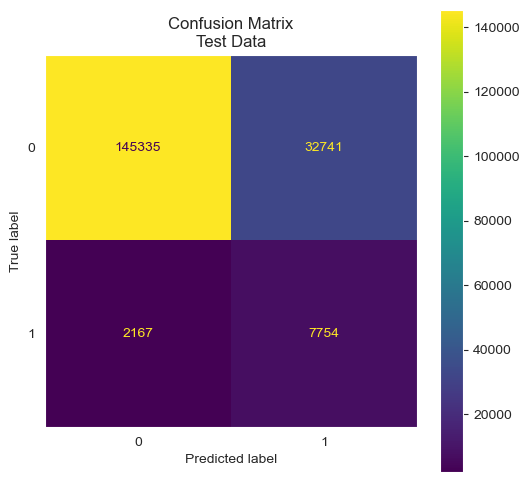

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.82      0.89    178076
           1       0.19      0.78      0.31      9921

    accuracy                           0.81    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.81      0.86    187997

Recall Score:
Train: 0.794
Test: 0.782 
False Positive Rate:
Train: 0.183
Test: 0.184 
AUC Score:
Train: 0.891
Test: 0.883 
Accuracy Score:
Train: 0.815
Test: 0.814 
Precision Score:
Train: 0.194
Test: 0.191 
F1 Score:
Train: 0.312
Test: 0.308 


In [424]:
# Evaluate the model
print('========'*8)
print('Neural Network With BinaryCrossentropy')
print('========'*8)
evaluator = ModelEvaluator(nn_model_bcentropy, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test_nn, y_train_nn, y_test)

#### Adjust Threshold & Reevaluation

In [60]:
# Create variable for target recall score
target_recall = 0.8000

# Get the probablistic prediction on test dataset
y_pred_test_proba = nn_model_bcentropy.predict(X_test_nn)  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 520us/step
For recall score to reach the target of 0.80, the threshold should be updated to: 0.4746


In [61]:
# Store the threshold
nn_thresholds = pd.DataFrame({'model': ['neural_network'], 'thresholds':[model_threshold]})
optimal_threshold_df = pd.concat([optimal_threshold_df, nn_thresholds], axis=0, ignore_index=True)
optimal_threshold_df

,model,thresholds
0,logistic_regression,0.448738
1,naive_bayes,0.271518
2,decision_tree,0.444043
3,random_forest,0.479093
4,xgboost,0.476502
5,neural_network,0.474640


Neural Network With BinaryCrossentropy
14100/14100 ━━━━━━━━━━━━━━━━━━━━ 8s 533us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 503us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

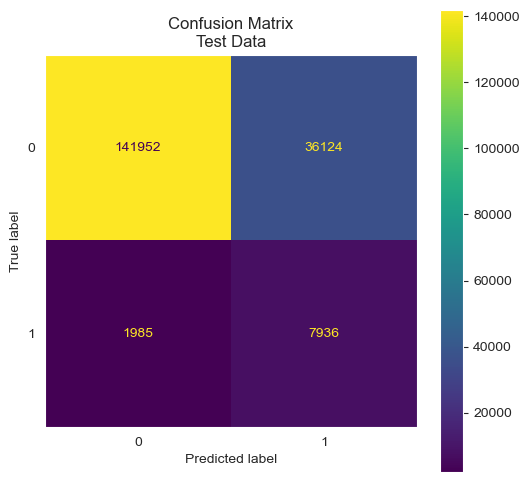

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.813
Test: 0.800 
False Positive Rate:
Train: 0.202
Test: 0.203 
AUC Score:
Train: 0.891
Test: 0.883 
Accuracy Score:
Train: 0.799
Test: 0.797 
Precision Score:
Train: 0.183
Test: 0.180 
F1 Score:
Train: 0.299
Test: 0.294 


In [427]:
# Reevaluate the model
print('========'*8)
print('Neural Network With BinaryCrossentropy')
print('========'*8)
evaluator = ModelEvaluator(nn_model_bcentropy, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test_nn, y_train_nn, y_test, thresholds=model_threshold)

In [92]:
# Store the metrics of neural network
recall_final_model.loc['Neural Network', : ] = [0.813, 0.800]
fpr_final_model.loc['Neural Network', : ] = [0.202, 0.203]

---

### 8.3 Neural Network With Customized Loss Function <a class="anchor" id="8c"></a>

#### Build customized loss function:
1. **Recap**: The metrics of success prioritize maximizing recall with a target of 0.8 while minimizing the false positive rate.
2. The customized loss function is defined as follows: <br>
loss = recall_weight * (1 - recall) + fpr_weight * fpr
3. Based on observations from previous modeling results, the recall values typically range from 0.76 to 0.79, which means (1 - recall) falls between 0.21 and 0.24. Meanwhile, the false positive rates range from 0.17 to 0.22. 
4. Therefore, setting both `recall_weight` and `fpr_weight` to 1 by default will encourage the neural network to prioritize maximizing recall slightly over minimizing the false positive rate. However, if I or the future user of this model want to further optimize recall, increasing `recall_weight` can help achieve that goal.

In [ ]:
def recall_fpr_loss(y_true, y_pred, recall_weight=1, fpr_weight=1):
    """
    Custom loss function for neural network for maximizing recall while minimizing false positive rate (fpr). 
    The loss fuction can be calculated using formula: loss = recall_weight * (1 - recall) + fpr_weight * fpr
    
    Args:
        y_true(array): True value of y
        y_pred(array): Predicted value of y
        recall_target(float): The rate of loss in recall, higher recall_weight will push 
            model to prioritize in maximize recall. Use 1 as default weight.
        fpr_weight(float): The rate of loss in recall, higher recall_weight will push 
            model to prioritize in minimize fpr. Use 1 as default weight.
    
    Return:
        loss(tensor): Customized loss as a combination of recall and loss
    """

    # Calculate TP and FP using probabilities (differentiable)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    
    # Calculate total positives and negatives
    total_positives = tf.reduce_sum(y_true) + tf.keras.backend.epsilon()
    total_negatives = tf.reduce_sum(1 - y_true) + tf.keras.backend.epsilon()

    # Calculate recall
    recall = tp / total_positives
    
    # Calculate false positive rate
    fpr = fp / total_negatives
    
    # Create loss
    loss = recall_weight * (1 - recall) + fpr_weight * fpr

    return loss

#### Build and Train Neural Network

In [395]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Set up the structure 
nn_model_customized_loss = Sequential([
    Dense(64, activation="relu"),   # Add hidden layer
    Dropout(0.3),  # Dropout layer with 30% dropout rate
    Dense(32, activation="relu"),   # Add hidden layer
    Dropout(0.3),  # Dropout layer with 30% dropout rate
    Dense(16, activation="relu"),   # Add hidden layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
nn_model_customized_loss.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), # Cutomized learning rate
    loss=lambda y_true, y_pred: recall_fpr_loss(y_true, y_pred, recall_weight=1, fpr_weight=1), # Use customized loss function
    metrics=[
        keras.metrics.Recall(name='recall'),      # Monitoring recall
        keras.metrics.FalsePositives(name='fp')  # Monitoring false positives
    ]
)

# Create early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [396]:
# Fit the model
nn_model_customized_loss.fit(
    X_train_nn,
    y_train_nn,
    class_weight = class_weights,
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=(X_val_nn, y_val_nn), 
    callbacks=[early_stopping]  # Set up early stopping to prevent overfitting
)

Epoch 1/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - fp: 88349.5625 - loss: 0.1474 - recall: 0.8119 - val_fp: 23030.0000 - val_loss: 0.4445 - val_recall: 0.7797
Epoch 2/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 47413.0156 - loss: 0.0923 - recall: 0.7762 - val_fp: 20877.0000 - val_loss: 0.4194 - val_recall: 0.7784
Epoch 3/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 43201.6445 - loss: 0.0866 - recall: 0.7771 - val_fp: 19448.0000 - val_loss: 0.4117 - val_recall: 0.7710
Epoch 4/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 42030.8242 - loss: 0.0844 - recall: 0.7783 - val_fp: 18578.0000 - val_loss: 0.4071 - val_recall: 0.7668
Epoch 5/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 40544.6016 - loss: 0.0837 - recall: 0.7740 - val_fp: 19599.0000 - val_loss: 0.4038 - val_recall: 0.7786
Epoch 6/100
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - fp: 40413.8359 - loss: 0.0825 - recall: 0.7788 - val_fp: 19151.0000 - val_loss: 0.4018 - val_recall: 0.7770
Epoch 7/10

#### Model Evaluation

Neural Network With Customized Loss Function
14100/14100 ━━━━━━━━━━━━━━━━━━━━ 11s 788us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 4s 761us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

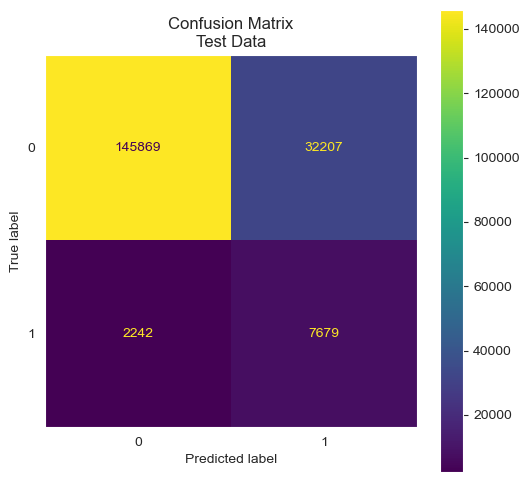

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.98      0.82      0.89    178076
           1       0.19      0.77      0.31      9921

    accuracy                           0.82    187997
   macro avg       0.59      0.80      0.60    187997
weighted avg       0.94      0.82      0.86    187997

Recall Score:
Train: 0.786
Test: 0.774 
False Positive Rate:
Train: 0.180
Test: 0.181 
AUC Score:
Train: 0.870
Test: 0.867 
Accuracy Score:
Train: 0.818
Test: 0.817 
Precision Score:
Train: 0.195
Test: 0.193 
F1 Score:
Train: 0.313
Test: 0.308 


In [397]:
# Evaluate the model
print('========'*8)
print('Neural Network With Customized Loss Function')
print('========'*8)
evaluator = ModelEvaluator(nn_model_customized_loss, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test_nn, y_train_nn, y_test)

#### Adjust Threshold & Reevaluation

In [399]:
# Create variable for target recall score
target_recall = 0.80

# Get the probablistic prediction on test dataset
y_pred_test = nn_model_customized_loss.predict(X_test_nn)  # find the probablitity of positive class

# find recall (tpr), false positive rate with the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Use for loop to find the thresholds whenever recall/tpr exceeds target_recall
for i in range(len(tpr)):
    if tpr[i] > target_recall:
        model_threshold = thresholds[i]
        print(f'For recall score to reach the target of 0.80, the threshold should be updated to: {model_threshold:.4f}')
        break

5875/5875 ━━━━━━━━━━━━━━━━━━━━ 4s 594us/step
For recall score to reach the target of 0.80, the threshold should be updated to: 0.0381


14100/14100 ━━━━━━━━━━━━━━━━━━━━ 8s 556us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step
Confusion matrices: 


<Figure size 300x300 with 0 Axes>

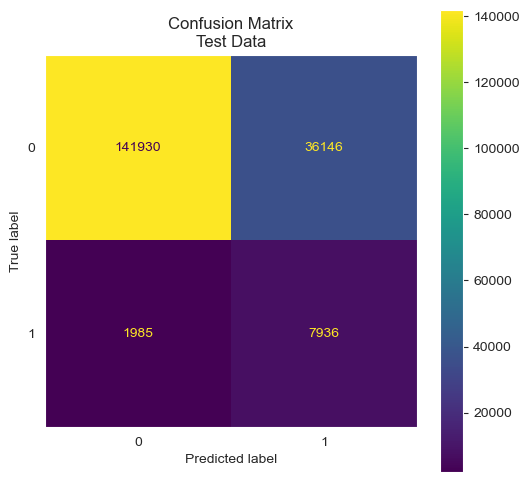

Test Data Classification Report: 
==================================================================               precision    recall  f1-score   support

           0       0.99      0.80      0.88    178076
           1       0.18      0.80      0.29      9921

    accuracy                           0.80    187997
   macro avg       0.58      0.80      0.59    187997
weighted avg       0.94      0.80      0.85    187997

Recall Score:
Train: 0.808
Test: 0.800 
False Positive Rate:
Train: 0.203
Test: 0.203 
AUC Score:
Train: 0.870
Test: 0.867 
Accuracy Score:
Train: 0.798
Test: 0.797 
Precision Score:
Train: 0.182
Test: 0.180 
F1 Score:
Train: 0.297
Test: 0.294 


In [400]:
# Re-evaluate the model using the new threshold
evaluator = ModelEvaluator(nn_model_customized_loss, is_neural_network=True)
evaluator.evaluate(X_train_nn, X_test_nn, y_train_nn, y_test, thresholds=model_threshold)

---

### 8.4 Neural Network Model Comparison & Summary <a class="anchor" id="8d"></a>

**Metrics using test data:** <br>
tf.random_set_seed(42), no PCA, Class weights adjusted based on the actual class distribution

| Model            | Loss Function          | Threshold | Recall | FPR   | AUC   | Accuracy | Precision | F1 Score | Notes          |
|------------------|------------------------|-----------|--------|-------|-------|----------|-----------|----------|-----------------|
| **Neural Network**    | **Binary Crossentropy**     | 0.4746    | 0.800  | 0.203 | **0.883** | 0.797    | 0.180     | 0.294    |  **Final**  |
| Neural Network    | Customize Loss Function | 0.0381    | 0.800  | 0.203 | 0.867 | 0.797    | 0.180     | 0.294    |   |


- The two models are nearly indistinguishable based on their metrics, as most of them are identical except for the AUC score.




- Show to ROC-AUC curves for both model:

ROC Curve: BinaryCrossentropy Model
14100/14100 ━━━━━━━━━━━━━━━━━━━━ 7s 509us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 483us/step


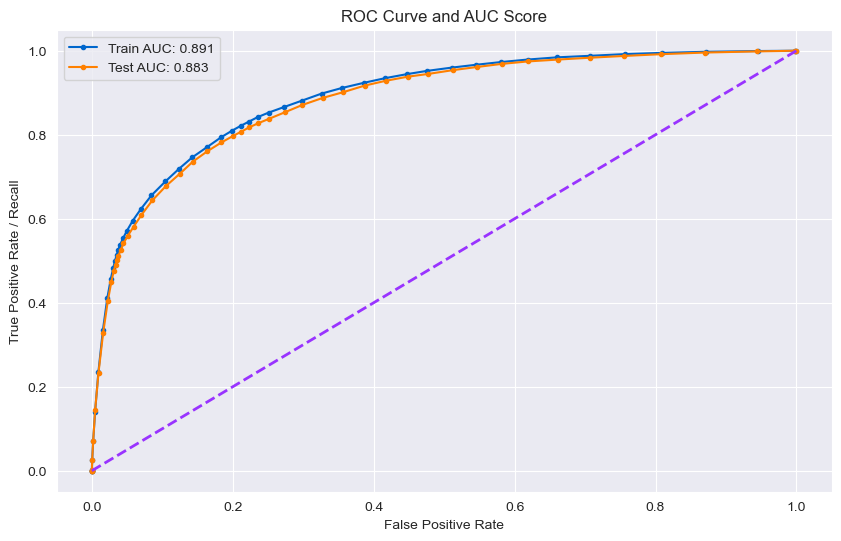

ROC Curve: Customized Loss Model
14100/14100 ━━━━━━━━━━━━━━━━━━━━ 7s 507us/step
5875/5875 ━━━━━━━━━━━━━━━━━━━━ 3s 514us/step


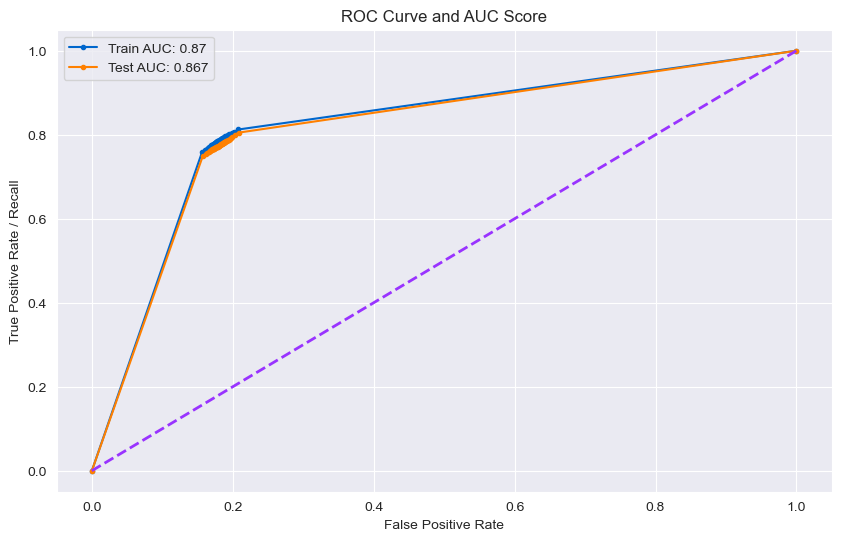

In [14]:
# Create a dictioary to store both model
nn_dict = {
    'BinaryCrossentropy Model' : nn_model_bcentropy,
    'Customized Loss Model' : nn_model_customized_loss
}

# Use a for loop to show the ROC-AUC curve for both models
for model_name, model in nn_dict.items():
    print('======='*8)
    print(f'ROC Curve: {model_name}')
    print('======='*8)
    evaluator = ModelEvaluator(model, is_neural_network=True)
    evaluator.plot_roc_auc_curve(X_train_nn, X_test_nn, y_train_nn, y_test)


- Below is a table outlining the characteristics that differentiate the two models:

| Aspect              | **BinaryCrossentropy Model**       | Customized Loss Model                 |
|---------------------|--------------------------------|-----------------------------------|
| ROC Smoothness      | Better calibrated probabilities | Focused on specific trade-off  (recall vs. fpr)   |
| Decision Threshold   | Works across all thresholds     | Optimized for particular fpr/recall (fpr around 0.2, recall around 0.8) |
| Deployment Cost     | Standard implementation         | May require additional monitoring      |
| Interpretability    | Well-understood behavior        | Behavior linked to loss weights. Users may need additional reading and explanation of the loss function.    |

- **Given that the Binary Crossentropy model is more standardized, generalizable, interpretable, and requires less monitoring after deployment, I have decided to select it as the final model for the neural network. Additionally, it shows a slight advantage in the AUC score.**

---

## 9. Advanced Model Comparison and Summary <a class="anchor" id="9"></a>

### 9.1 Model Comparison and Final Model Selection  <a class="anchor" id="9a"></a>

Create a plot displaying the training and testing recall scores, along with the false positive rates.

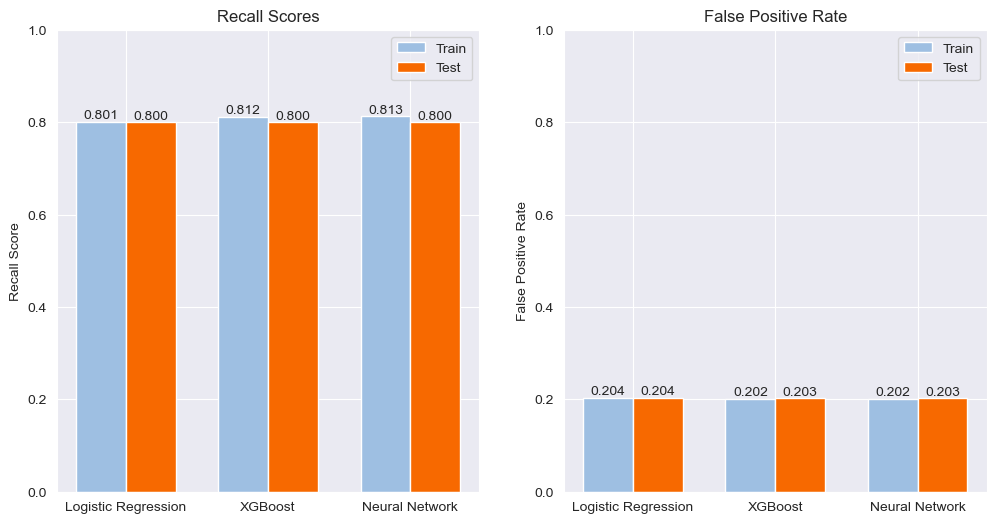

In [115]:
# Create two DataFrames for storing the metrics of top three models
recall_best_model = recall_final_model.loc[['Logistic Regression', 'XGBoost', 'Neural Network']]
fpr_best_model = fpr_final_model.loc[['Logistic Regression', 'XGBoost', 'Neural Network']]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set up bar width and list of number of models
bar_width = 0.35
x = range(len(recall_best_model))

# Create first subplot, show the train and test recall score of top three models
train_bars = axes[0].bar(x, recall_best_model['Train'], width=bar_width,  label='Train', color='#9EBFE2')
test_bars = axes[0].bar([i + bar_width for i in x], recall_best_model['Test'], width=bar_width, label='Test', color='#F76900')

# Annotate train and test recall scores on top of the bar
for bar in train_bars:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.3f}', 
                 ha='center', va='bottom')
    
for bar in test_bars:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.3f}', 
                 ha='center', va='bottom')

# Set plot params
axes[0].set_xticks([i + bar_width / 2 for i in x])
axes[0].set_xticklabels(recall_best_model.index)  
axes[0].set_title('Recall Scores')
axes[0].set_ylabel('Recall Score')
axes[0].set_ylim(0, 1)
axes[0].legend()


# Create second subplot, show the train and test fpr of top three models
train_bars = axes[1].bar(x, fpr_best_model['Train'], width=bar_width,  label='Train', color='#9EBFE2')
test_bars = axes[1].bar([i + bar_width for i in x], fpr_best_model['Test'], width=bar_width, label='Test', color='#F76900')

# Annotate train and test fpr scores on top of the bar
for bar in train_bars:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.3f}', 
                 ha='center', va='bottom')
    
for bar in test_bars:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.3f}', 
                 ha='center', va='bottom')

# Set plot params
axes[1].set_xticks([i + bar_width / 2 for i in x])
axes[1].set_xticklabels(fpr_best_model.index)  
axes[1].set_title('False Positive Rate')
axes[1].set_ylabel('False Positive Rate')
axes[1].set_ylim(0, 1)
axes[1].legend()


**Metrics using test data:**

| Model              | Recall | FPR   | AUC   | Accuracy | Precision | F1 | Hyperparameters                                      | Threshold |
|--------------------|--------|-------|-------|----------|-----------|----------|------------------------------------------------------|-----------|
| **Logistic Regression** | **0.800**  | **0.204** | 0.881 | 0.796    | 0.179     | 0.293    | C=0.001, penalty=l2, solver=saga                     | 0.4487    |
| XGBoost            | 0.800  | 0.203 | 0.883 | 0.797    | 0.180     | 0.294    | n_estimators=40, learning_rate=0.12, max_depth=11, min_child_weight=10, subsample=0.7, reg_alpha=1, reg_lambda=10 | 0.4765    |
| Neural Network     | 0.800  | 0.203 | 0.883 | 0.797    | 0.180     | 0.294    | 3 hidden layers (64, 32, 16 neurons), Dropout: 0.3, Early Stopping: Enabled, Batch Size: 256 | 0.4746    |
| Naive Bayes        | 0.800  | 0.257 | 0.835 | 0.746    | 0.148     | 0.250    | var_smoothing= 0.001                                  | 0.2715    |
| Decision Tree      | 0.797  | 0.223 | 0.870 | 0.778    | 0.166     | 0.275    | max_depth=11, min_samples_split=4, min_samples_leaf=80, criterion=entropy | 0.4440    |
| Random Forest      | 0.800  | 0.216 | 0.878 | 0.785    | 0.171     | 0.282    | max_depth=16, min_samples_leaf=80, min_samples_split=3, n_estimators=100, bootstrap=False | 0.4791    |


1. Overfitting Issue: Overfitting was identified in baseline models, particularly with XGBoost, Decision Tree, and Random Forest, where recall and false positive rates were notably worse on the test data. This issue has been resolved in all advanced models through hyperparameter tuning.
2. Threshold Adjustment: As outlined in the introduction of this notebook, thresholds were adjusted in different models to achieve a target recall score of 0.8. Consequently, **all models can identify 80% of users who face the risk of heart attack.**
3. False Positive Rate: The false positive rate (FPR), which represents the proportion of false alarms, varies across models. Most models maintain similar FPRs, successfully keeping them below 0.22. Specifically, the FPR for Logistic Regression, XGBoost, and Neural Network is almost identical, with only a 0.001 difference.
4. Model Comparison of Logistic Regression, XGBoost, and Neural Network:
    - Compared to XGBoost and Neural Network, Logistic Regression is simpler and more interpretable. This interpretability is crucial for understanding the features that contribute to predictions of having a heart attack, enabling users to take preventive actions against heart attack risks.
    - Among the three models, Logistic Regression generalizes better than XGBoost and Neural Network, as evidenced by the closer difference between train and test recall scores, indicating lower variance. <br>

**Therefore, I have chosen Logistic Regression as the best performer and the final model for deployment and analysis.**

---

### 9.2 Understanding the Metrics <a class="anchor" id="9b"></a>
- TThe final model achieves a recall score of 0.80, indicating that it correctly identifies 80% of users who are actually at risk of having a heart attack.
- The final model has a false positive rate of 0.204, meaning that 20.4% of individuals who do not face the risk of a heart attack receive a false positive alarm.

---

## 10 Export Model and Thresholds <a class="anchor" id="10"></a>


In [118]:
# Export the advanced modeling models
joblib.dump(pipeline_logreg_final, "../models/advanced_model/pipeline_logreg_advanced.joblib")   
joblib.dump(pipeline_nb_final, "../models/advanced_model/pipeline_nb_advanced.joblib")
joblib.dump(pipeline_dt_final, "../models/advanced_model/pipeline_dt_advanced.joblib")
joblib.dump(pipeline_rf_final, "../models/advanced_model/pipeline_rf_advanced.joblib")
joblib.dump(pipeline_xgb_final, "../models/advanced_model/pipeline_xgb_advanced.joblib")
nn_model_bcentropy.save("../models/advanced_model/nn_model_bcentropy.keras")

# Export the thresholds used for advanced modeling
optimal_threshold_df.to_csv("../models/advanced_model/model_thresholds.csv", index=False)

In [119]:
# Extract the thresholds for final models
logreg_threshold = optimal_threshold_df[optimal_threshold_df['model'] == 'logistic_regression']
logreg_threshold

,model,thresholds
0,logistic_regression,0.448738


In [120]:
# Export the final model
joblib.dump(pipeline_logreg_final, "../models/final_model/pipeline_logreg_final.joblib")  

# Export the thresholds used for final model
logreg_threshold.to_csv("../models/final_model/logreg_threshold.csv", index=False)